In [ ]:
import numpy as np
import pandas as pd

import os, sys
import random

try:
    os.chdir('CrowdInference')
    sys.path.append(os.getcwd())
except:
    pass

import crowd_inference.methods.dawid_skene as ds
import crowd_inference.methods.majority_vote as mv
import crowd_inference.methods.raykar as r
import crowd_inference.methods.raykar_plus_ds as rds
from crowd_inference.truth_inference import NoFeaturesInference, TruthInference, WithFeaturesInference
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from collections import defaultdict
import tests.data_provider as data
from typing import Iterable, Dict, List, Optional, Tuple

from importlib import reload

# def reload_all():
#     reload(ds)
#     reload(r)
#     reload(rds)
#     reload(data)

In [29]:
# import csv
# import pickle

# import numpy as np
# import pandas as pd
# from abc import abstractmethod
# from typing import Iterable, Dict, List, Optional, Tuple

# from crowd_inference.model.annotation import Annotation
# from crowd_inference.model.estimation import Estimation


# class DataProvider:

#     @abstractmethod
#     def labels(self) -> Iterable[Annotation]:
#         pass

#     @abstractmethod
#     def gold(self) -> Iterable[Estimation]:
#         pass


# class SimpleGeneratedDataProvider(DataProvider):
#     def __init__(self):
#         self._simple_labels = []
#         self._simple_labels.append(Annotation('1', '1', 'T'))
#         self._simple_labels.append(Annotation('1', '2', 'T'))
#         self._simple_labels.append(Annotation('1', '3', 'T'))
#         self._simple_labels.append(Annotation('2', '1', 'F'))
#         self._simple_labels.append(Annotation('2', '2', 'F'))
#         self._simple_labels.append(Annotation('2', '3', 'F'))
#         self._simple_labels.append(Annotation('3', '1', 'T'))
#         self._simple_labels.append(Annotation('3', '2', 'T'))
#         self._simple_labels.append(Annotation('3', '3', 'F'))

#         self._simple_gold = []
#         self._simple_gold.append(Estimation('1', 'F'))
#         self._simple_gold.append(Estimation('2', 'T'))
#         self._simple_gold.append(Estimation('3', 'T'))

#     def labels(self) -> Iterable[Annotation]:
#         return self._simple_labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._simple_gold


# class RelDataProvider(DataProvider):
#     def __init__(self, path: str):
#         self._rel_labels = []
#         self._rel_gold = set()
#         with open(path, newline='') as csvfile:
#             file_reader = csv.reader(csvfile, delimiter='\t')
#             next(file_reader)
#             for row in file_reader:
#                 self._rel_labels.append(Annotation(row[1], row[0] + '#' + row[2], row[4]))
#                 gold = row[3]
#                 if gold != '-1':
#                     self._rel_gold.add(Estimation(row[0] + '#' + row[2], gold))

#     def labels(self) -> Iterable[Annotation]:
#         return self._rel_labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._rel_gold


# class AdultsDataProvider(DataProvider):
#     def __init__(self, labels_path: str, gold_path: str):
#         self._adult_labels = []
#         self._adult_gold = []
#         with open(labels_path, newline='') as csvfile:
#             file_reader = csv.reader(csvfile, delimiter='\t')
#             for row in file_reader:
#                 self._adult_labels.append(Annotation(row[0], row[1], row[2]))
#         with open(gold_path, newline='') as csvfile:
#             file_reader = csv.reader(csvfile, delimiter='\t')
#             for row in file_reader:
#                 self._adult_gold.append(Estimation(row[0], row[1]))

#     def labels(self) -> Iterable[Annotation]:
#         return self._adult_labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._adult_gold


# class MusicDataProvider(DataProvider):
#     ANNOTATIONS_PATH = './resources/datasets/music_genre/music_genre_mturk.csv'
#     GOLD_PATH = './resources/datasets/music_genre/music_genre_gold.csv'
#     TEST_PATH = './resources/datasets/music_genre/music_genre_test.csv'
    
#     def __init__(self):
#         self._music_labels = []
#         self._music_gold = []
#         self._features = {}
#         data = pd.read_csv(self.ANNOTATIONS_PATH)
#         for _, row in data.iterrows():
#             self._music_labels.append(Annotation(row['annotator'], row['id'], row['class']))

#         for id_, group in data.groupby(['id']):
#             gold = id_.split('.')[0]
#             self._music_gold.append(Estimation(id_, gold))
            
#         def get_features(x):
#             return x[1:-1]
        
#         gold = pd.read_csv(self.GOLD_PATH)
#         n_features = None
#         for _, row in gold.iterrows():
#             features = get_features(row.values)
#             self._features[row['id']] = np.concatenate([features, [1]])
#             n_features = len(features) + 1
            
#         test = pd.read_csv(self.TEST_PATH)
#         n = len(test)
#         self.X = np.zeros((n, n_features))
#         self.y = []
        
#         for i, row in test.iterrows():
#             features = get_features(row.values)
#             self.X[i] = np.concatenate([features, [1]])
#             self.y.append(row.values[-1])
            
#         self.y = np.array(self.y)

#     def labels(self) -> Iterable[Annotation]:
#         return self._music_labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._music_gold
    
#     def features(self) -> Dict[str, np.ndarray]:
#         return self._features
    
#     def test(self) -> Tuple[np.ndarray, np.ndarray]:
#         return self.X, self.y



# class SentimentDataProvider(DataProvider):
#     TEST_PATH = './resources/datasets/sentiment_polarity/polarity_test_lsa_topics.csv'
    
#     def __init__(self, labels_path: str, gold_path: str):
#         self._sentiment_labels = []
#         self._sentiment_gold = []
#         self._features = {}
#         labels = pd.read_csv(labels_path)
#         for _, row in labels.iterrows():
#             self._sentiment_labels.append(Annotation(row['WorkerId'], row['Input.id'], row['Answer.sent']))

#         gold = pd.read_csv(gold_path)
        
#         def get_features(x):
#             return x[1:-1:3]
        
#         n_features = None
#         for _, row in gold.iterrows():
#             self._sentiment_gold.append(Estimation(row['id'], row['class']))
#             features = get_features(row.values)
#             self._features[row['id']] = features
#             n_features = len(features)
        
#         test = pd.read_csv(self.TEST_PATH)
#         n = len(test)
#         self.X = np.zeros((n, n_features))
#         self.y = []
        
#         for i, row in test.iterrows():
#             features = get_features(row.values)
#             self.X[i] = features
#             self.y.append(row.values[-1])
            
#         self.y = np.array(self.y)

#     def labels(self) -> Iterable[Annotation]:
#         return self._sentiment_labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._sentiment_gold

#     def features(self) -> Dict[str, np.ndarray]:
#         return self._features
    
#     def test(self) -> Tuple[np.ndarray, np.ndarray]:
#         return self.X, self.y

# class IonosphereProvider(DataProvider):
#     def __init__(self, save_path, resample: bool = False, path: Optional[str] = None,
#                  flip_probs: Optional[List[float]] = None,
#                  annotate_prob: Optional[float] = None):
#         self._labels = []
#         self._gold = []
#         self._features = {}

#         if not resample:
#             with open(save_path, 'rb') as f:
#                 self._labels, self._gold, self._features = pickle.load(f)
#             return

#         data = pd.read_csv(path)
#         for i, row in data.iterrows():
#             for _ in range(10):
#                 has_annotation = np.random.binomial(1, annotate_prob, len(flip_probs))
#                 while has_annotation.sum() == 0:
#                     has_annotation = np.random.binomial(1, annotate_prob, len(flip_probs))
#                 for j, p in enumerate(flip_probs):
#                     if has_annotation[j]:
#                         if np.random.binomial(1, 1 - p):
#                             label = row[-1]
#                         else:
#                             label = 'b' if row[-1] == 'g' else 'g'
#                         self._labels.append(Annotation(str(j), str(i), label))
#         print(len(self._labels))
#         for i, row in data.iterrows():
#             to_array = row.values
#             to_array[1] += 1  # Fix zero feature
#             self._gold.append(Estimation(str(i), to_array[-1]))
#             self._features[str(i)] = to_array[:-1]

#         with open(save_path, 'wb') as f:
#             pickle.dump((self._labels, self._gold, self._features), f)

#     def labels(self) -> Iterable[Annotation]:
#         return self._labels

#     def gold(self) -> Iterable[Estimation]:
#         return self._gold

#     def features(self) -> Dict[str, np.ndarray]:
#         return self._features


In [30]:
sentiment_data = SentimentDataProvider('./resources/datasets/sentiment_polarity/mturk_answers.csv',
                                       './resources/datasets/sentiment_polarity/polarity_gold_lsa_topics.csv')

In [31]:
reload(ds)
reload(r)
reload(rds)

flip_probs = [0.1, 0.2, 0.3, 0.5, 0.6]
# flip_probs = [0.3]
ionosphere_data = IonosphereProvider('./resources/datasets/ionosphere/ionosphere.pickle', 
                                     resample=True,
                                     path='./resources/datasets/ionosphere/ionosphere.csv',
                                     flip_probs=flip_probs,
                                     annotate_prob=0.7)
music_data = MusicDataProvider()

def features2np(provider: DataProvider) -> Tuple[np.ndarray, np.ndarray]:
    features = provider.features()
    n_features = len(features[list(features.keys())[0]])
    n_tasks = len(features)
    X = np.zeros((n_tasks, n_features))
    y = []
    for i, estimation in enumerate(provider.gold()):
        X[i] = features[estimation.task]
        y.append(estimation.value)
    
    return X, np.array(y)
        

def get_classifier_accuracy(inference: WithFeaturesInference, data_provider: DataProvider):
    X, y = features2np(data_provider)
    classification = inference.apply_classifier(X)
    accuracy = accuracy_score(y, classification)
    print(f'Classifier train accuracy is {accuracy}')
    
    correct_test = 0
    if not isinstance(data_provider, IonosphereProvider):
        X, y = data_provider.test()
        classification = inference.apply_classifier(X)
        test_accuracy = accuracy_score(y, classification)
        print(f'Classifier test accuracy is {test_accuracy}')


def _get_accuracy(provider: DataProvider, inference: TruthInference, max_iter: int):
    correct = []
    incorrect = []
    accepted = 0
    all_points = 0
    estimates = {}

    if isinstance(inference, WithFeaturesInference):
        inference.fit(provider.labels(), provider.features(), max_iter=max_iter)
        get_classifier_accuracy(inference, provider)
    elif isinstance(inference, NoFeaturesInference):
        inference.fit(provider.labels(), max_iter=15)

    for estimate in inference.estimate():
        estimates[estimate.task] = estimate.value
    for point in provider.gold():
        if point.task in estimates:
            estimate = estimates[point.task]
            all_points += 1
            if point.value == estimate:
                accepted += 1
                correct.append(point)
            else:
                incorrect.append(point)

    accuracy = accepted / all_points
    print(f'Label accuracy is {accuracy}')

    return accuracy, {e.task for e in correct}, {e.task for e in incorrect}


def compare_methods(provider, max_iter=15):
    results = []
    points_results = []
    methods = [ds.DawidSkene(), r.Raykar(), rds.RaykarPlusDs()]
    points = []
    
    for method in methods:
        accuracy, correct, incorrect = _get_accuracy(provider, method, max_iter)
        results.append((method.__str__(), accuracy))
        plt.plot(method.logit_)
        points_results.append((correct, incorrect))
        print('-' * 50)
        task, mu, method_rds, classifier, likelihood_rds, conf_mx = [], [], [], [], [], []
        for k, v in method.predictions_.items():
            task.append(k)
            mu.append(np.round(v[1], 2))
            if isinstance(method, WithFeaturesInference):
                classifier.append(np.round(v[2], 2))
            if isinstance(method, rds.RaykarPlusDs):
                method_rds.append("R" if v[3] else "DS")
                likelihood_rds.append(np.round(v[4], 3))
                conf_mx.append(np.round(v[5], 3))
        
        columns = {'task': task, 'mu': mu}
        if len(classifier):
            columns['classifier'] = classifier
        if len(method_rds):
            columns['method_rds'] = method_rds
            columns['likelihood_rds'] = likelihood_rds
            columns['conf_mx_rds'] = conf_mx
        points.append(pd.DataFrame(columns))
        
    points_aggregated = points[1].merge(points[2], on='task', suffixes=('_r', '_rds'))
    points_aggregated = points_aggregated.merge(points[0], on='task')
    points_aggregated.rename(columns={'mu': 'mu_ds'}, inplace=True)

        
    plt.legend(list(map(str, methods)))

    # Get points advantages
    advantages = []
    for i in range(len(methods)):
        advantages.append([])
        for j in range(len(methods)):
            advantages[i].append(points_results[i][0] - points_results[j][0])
    
    return methods, points_aggregated, advantages

def print_conf(methods):
    assessors = []
    for m in methods:
        print(m)
        print(m.conf_mx[:, 0, 0])
        print(m.conf_mx[:, 1, 1])
        
def shuffle_features(data):
    features_list = []
    for k in data._features.keys():
        features_list.append(data._features[k])
    random.shuffle(features_list)
    for k, f in zip(data._features.keys(), features_list):
        data._features[k] = f

12320


Iter 00, logit: -22.462774
Label accuracy is 1.0
--------------------------------------------------
Data has 34 features
Iter 00, logit: -22.466279
Iter 10, logit: -19.998719
Iter 20, logit: -19.886008
Iter 30, logit: -19.838375
Iter 40, logit: -19.817001
Iter 50, logit: -19.808937
Iter 60, logit: -19.807130
Iter 70, logit: -19.806791
Iter 80, logit: -19.806724
Iter 90, logit: -19.806707
Classifier train accuracy is 0.9371428571428572
Label accuracy is 1.0
--------------------------------------------------
Data has 34 features
Iter 00, logit: -22.420907
Average Raykar weight is 0.36
Iter 10, logit: -19.980576
Average Raykar weight is 0.8771428571428571
Iter 20, logit: -19.858639
Average Raykar weight is 0.9142857142857143
Iter 30, logit: -19.800705
Average Raykar weight is 0.9257142857142857
Iter 40, logit: -19.774417
Average Raykar weight is 0.9228571428571428
Iter 50, logit: -19.761767
Average Raykar weight is 0.9371428571428572
Iter 60, logit: -19.756438
Average Raykar weight is 0.9

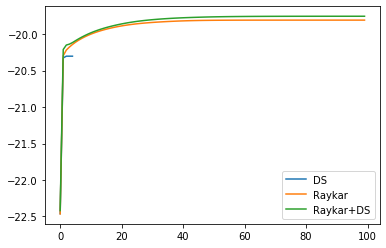

In [32]:
reload(ds)
reload(r)
reload(rds)

ionosphere_methods, points, advantages_matrix = compare_methods(ionosphere_data, max_iter=100)
print_conf(ionosphere_methods)

In [14]:
advantages_matrix[1][0]

{'101',
 '110',
 '116',
 '126',
 '137',
 '154',
 '155',
 '189',
 '194',
 '204',
 '229',
 '233',
 '253',
 '255',
 '258',
 '260',
 '287',
 '292',
 '298',
 '3',
 '308',
 '31',
 '313',
 '314',
 '324',
 '336',
 '34',
 '35',
 '37',
 '40',
 '41',
 '59',
 '70',
 '93',
 '96'}

In [15]:
points[points.task.isin(advantages_matrix[1][2])]

,task,mu_r,classifier_r,mu_rds,classifier_rds,method_rds,likelihood_rds,conf_mx_rds,mu_ds
4,101,"[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[0.99, 0.01]",DS,"[0.185, 0.003]","[0.001, 0.302]","[0.02, 0.98]"
14,110,"[0.07, 0.93]","[0.02, 0.98]","[1.0, 0.0]","[0.12, 0.88]",DS,"[0.053, 0.017]","[0.138, 0.0]","[0.68, 0.32]"
20,116,"[0.11, 0.89]","[0.03, 0.97]","[1.0, 0.0]","[0.11, 0.89]",DS,"[0.027, 0.008]","[0.071, 0.0]","[0.73, 0.27]"
43,137,"[0.54, 0.46]","[0.77, 0.23]","[0.2, 0.8]","[0.78, 0.22]",DS,"[0.096, 0.034]","[0.081, 0.196]","[0.2, 0.8]"
62,154,"[0.26, 0.74]","[0.1, 0.9]","[0.69, 0.31]","[0.24, 0.76]",DS,"[0.101, 0.064]","[0.381, 0.106]","[0.74, 0.26]"
100,189,"[1.0, 0.0]","[1.0, 0.0]","[0.06, 0.94]","[0.48, 0.52]",DS,"[0.034, 0.028]","[0.006, 0.058]","[0.3, 0.7]"
108,196,"[0.19, 0.81]","[0.18, 0.82]","[1.0, 0.0]","[0.3, 0.7]",DS,"[0.017, 0.013]","[0.043, 0.0]","[0.46, 0.54]"
145,229,"[1.0, 0.0]","[1.0, 0.0]","[0.17, 0.83]","[1.0, 0.0]",DS,"[0.196, 0.023]","[0.13, 0.386]","[0.19, 0.81]"
158,240,"[0.03, 0.97]","[0.02, 0.98]","[1.0, 0.0]","[0.14, 0.86]",DS,"[0.008, 0.003]","[0.021, 0.0]","[0.45, 0.55]"
172,253,"[0.15, 0.85]","[0.12, 0.88]","[0.59, 0.41]","[0.51, 0.49]",R,"[0.012, 0.016]","[0.053, 0.038]","[0.53, 0.47]"


Iter 00, logit: -3.010473
Iter 10, logit: -2.779897
Label accuracy is 0.9147829565913183
--------------------------------------------------
Data has 400 features
Iter 00, logit: -2.995602
Iter 10, logit: -2.683408
Classifier train accuracy is 0.6787357471494299
Classifier test accuracy is 0.6217759764185704
Label accuracy is 0.9167833566713343
--------------------------------------------------
Data has 400 features
Iter 00, logit: -2.970825
Average Raykar weight is 0.5083016603320664
Iter 10, logit: -2.622094
Average Raykar weight is 0.6863372674534907
Average Raykar weight is 0.6883376675335067
Classifier train accuracy is 0.6799359871974395
Classifier test accuracy is 0.6226971260132645
Label accuracy is 0.9155831166233247
--------------------------------------------------


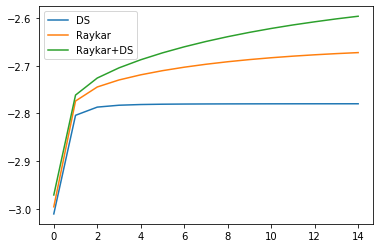

In [926]:
reload(ds), reload(r), reload(rds)

sentiment_methods = compare_methods(sentiment_data, max_iter=15)
# print_conf(sentiment_methods)

Iter 00, logit: -7.202692
Iter 10, logit: -6.147112
Label accuracy is 0.78
--------------------------------------------------
Data has 125 features
Iter 00, logit: -7.235968
Iter 10, logit: -6.179284
Iter 20, logit: -6.152358
Iter 30, logit: -6.144681
Iter 40, logit: -6.140193
Iter 50, logit: -6.137345
Iter 60, logit: -6.135756
Iter 70, logit: -6.134609
Iter 80, logit: -6.133421
Iter 90, logit: -6.132313
Classifier train accuracy is 0.7485714285714286
Classifier test accuracy is 0.57
Label accuracy is 0.7685714285714286
--------------------------------------------------
Data has 125 features
Iter 00, logit: -7.159576
Average Raykar weight is 0.3028571428571429
Iter 10, logit: -6.106900
Average Raykar weight is 0.53
Iter 20, logit: -6.087877
Average Raykar weight is 0.4942857142857143
Iter 30, logit: -6.080936
Average Raykar weight is 0.4471428571428571
Iter 40, logit: -6.077329
Average Raykar weight is 0.5328571428571428
Iter 50, logit: -6.075510
Average Raykar weight is 0.53
Iter 60, 

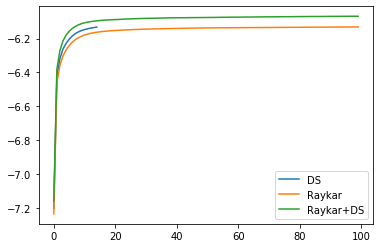

In [927]:
# for k in music_data._features.keys():
#     music_data._features[k] = np.random.rand(len(music_data._features[k]))

reload(ds), reload(r), reload(rds)
music_methods = compare_methods(music_data, max_iter=100)

Iter 00, logit: -2.757323
Iter 10, logit: -2.580053
Label accuracy is 0.84
--------------------------------------------------
Data has 34 features
Iter 00, logit: -2.764544
Iter 10, logit: -2.521609
Iter 20, logit: -2.465274
Iter 30, logit: -2.427392
Iter 40, logit: -2.398512
Iter 50, logit: -2.373968
Iter 60, logit: -2.354034
Iter 70, logit: -2.340844
Iter 80, logit: -2.335226
Iter 90, logit: -2.336213
Classifier train accuracy is 0.6571428571428571
Label accuracy is 0.84
--------------------------------------------------
Data has 34 features
Iter 00, logit: -2.714245
Average Raykar weight is 0.4257142857142857
Iter 10, logit: -2.472603
Average Raykar weight is 0.5914285714285714
Iter 20, logit: -2.367086
Average Raykar weight is 0.5885714285714285
Iter 30, logit: -2.288061
Average Raykar weight is 0.6171428571428571
Iter 40, logit: -2.262749
Average Raykar weight is 0.6171428571428571
Iter 50, logit: -2.255275
Average Raykar weight is 0.6371428571428571
Iter 60, logit: -2.251991
Aver

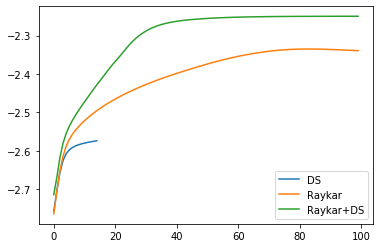

In [697]:
reload(ds)
reload(r)
reload(rds)

shuffle_features(ionosphere_data)

ionosphere_methods = compare_methods(ionosphere_data, max_iter=100)
print_conf(ionosphere_methods)

Iter 00, logit: -3.010473
Iter 10, logit: -2.779897
Label accuracy is 0.9147829565913183
--------------------------------------------------
Data has 400 features
Iter 00, logit: -3.004359
Iter 10, logit: -2.743197
Classifier train accuracy is 0.5989197839567914
Classifier test accuracy is 0.5167649226234341
Label accuracy is 0.9155831166233247
--------------------------------------------------
Data has 400 features
Iter 00, logit: -2.975496
Average Raykar weight is 0.4902980596119224
Iter 10, logit: -2.691276
Average Raykar weight is 0.613122624524905
Average Raykar weight is 0.6129225845169034
Classifier train accuracy is 0.5989197839567914
Classifier test accuracy is 0.5162122328666175
Label accuracy is 0.9155831166233247
--------------------------------------------------
[('DS', 0.9147829565913183), ('Raykar', 0.9155831166233247), ('Raykar+DS', 0.9155831166233247)]


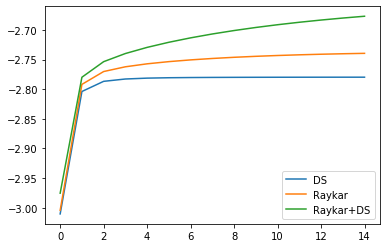

In [695]:
reload(ds), reload(r), reload(rds)

shuffle_features(sentiment_data)

sentiment_methods = compare_methods(sentiment_data, max_iter=15)
# print_conf(sentiment_methods)

Iter 00, logit: -7.202692
Iter 10, logit: -6.147112
Label accuracy is 0.78
--------------------------------------------------
Data has 125 features
Iter 00, logit: -7.235999
Iter 10, logit: -6.179787
Iter 20, logit: -6.153348
Iter 30, logit: -6.146201
Iter 40, logit: -6.142273
Iter 50, logit: -6.139997
Iter 60, logit: -6.138892
Iter 70, logit: -6.138068
Iter 80, logit: -6.137249
Iter 90, logit: -6.136554
Classifier train accuracy is 0.4
Classifier test accuracy is 0.12666666666666668
Label accuracy is 0.7671428571428571
--------------------------------------------------
Data has 125 features
Iter 00, logit: -7.158131
Average Raykar weight is 0.32285714285714284
Iter 10, logit: -6.107869
Average Raykar weight is 0.5157142857142857
Iter 20, logit: -6.088926
Average Raykar weight is 0.5157142857142857
Iter 30, logit: -6.083594
Average Raykar weight is 0.5171428571428571
Iter 40, logit: -6.078464
Average Raykar weight is 0.5157142857142857
Iter 50, logit: -6.074632
Average Raykar weight is

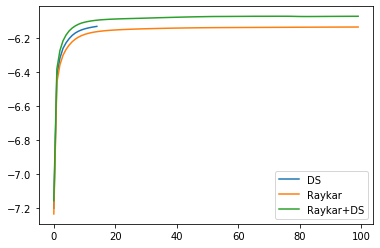

In [698]:
reload(ds), reload(r), reload(rds)
shuffle_features(music_data)
music_methods = compare_methods(music_data, max_iter=100)

In [63]:
a = np.array([[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]])
b = np.array([5, 6, 7]).reshape(-1, 1)
np.hstack([b] * 2)

array([[5, 5],
       [6, 6],
       [7, 7]])

In [39]:
#!:bash 

bash: line 11: jupyter: command not found


Check sentiment dataset

In [572]:
X_train, y_train = features2np(sentiment_data)

reg = LogisticRegression().fit(X_train, y_train)

X_test, y_test = sentiment_data.test()

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))

pred = reg.predict(X_test)
print(accuracy_score(y_test, pred))

0.8525705141028206
0.720891672807664


In [573]:
print(X_test.shape, X_train.shape)

(5428, 1200) (4999, 1200)


In [576]:
len(sentiment_data.gold())

4999

In [577]:
(y_test == 'pos').sum() / len(y_test)

0.5007369196757553

In [578]:

X_train, y_train = features2np(music_data)
X_train[:, -1] = 1

reg = LogisticRegression().fit(X_train, y_train)

X_test, y_test = music_data.test()
X_test[:, -1] = 1

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))

pred = reg.predict(X_test)
print(accuracy_score(y_test, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6185714285714285
0.57


In [585]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore').fit(y_train[:, None])
y_train1 = enc.transform(y_train[:, None]).toarray()
y_test1 = enc.transform(y_test[:, None]).toarray()
y_train1.shape

(700, 10)

(10, 124)
(700, 10)
6.510070260645762e-14
(700, 10)
4.2359171725792066e-13
(700, 10)
8.433254095052689e-13
(700, 10)
4.4633741147492856e-13
(700, 10)
1.6536771951791707e-13
(700, 10)
6.778466676848893e-13
(700, 10)
1.2206902155753596e-12
(700, 10)
1.3403722576299515e-12
(700, 10)
1.1212142325689456e-12
(700, 10)
1.195155086008981e-12
(700, 10)
1.0453859999870474e-12
(700, 10)
7.752687380957468e-13
(700, 10)
1.0225154056797692e-12
(700, 10)
1.7428281040565707e-12
(700, 10)
1.1072254224586686e-12
(700, 10)
2.1059820554114594e-12
(700, 10)
3.4223734957095076e-12
(700, 10)
3.3852920466870273e-12
(700, 10)
2.8739233215446802e-12
(700, 10)
3.1892266605382247e-12
(700, 10)
3.935074488481405e-12
(700, 10)
3.6703973194107675e-12
(700, 10)
3.5225156125306967e-12
(700, 10)
3.504307954926844e-12
(700, 10)
2.9456437289354653e-12
(700, 10)
3.3104630148272918e-12
(700, 10)
3.4379166180542597e-12
(700, 10)
3.3570923818615483e-12
(700, 10)
3.5726976932437537e-12
(700, 10)
3.864020214905395e-12
(700, 10

In [725]:
def consistency(data, iters=100000):
    cnt = 0
    task2annotations = defaultdict(list)
    for a in data.labels():
        task2annotations[a.task].append(a)
    for _ in range(iters):
        a = random.choice(data.labels())
        if len(task2annotations[a.task]) == 1:
#             cnt+=1
            continue
        b = random.choice(task2annotations[a.task])
        while a == b:
            b = random.choice(task2annotations[a.task])
        if a.value == b.value:
            cnt += 1
    return cnt / iters
print(f"Ionosphere consistency is {consistency(ionosphere_data)}")
print(f"Sentiment consistency is {consistency(sentiment_data)}")
print(f"Music consistency is {consistency(music_data)}")

Ionosphere consistency is 0.54705
Sentiment consistency is 0.71477
Music consistency is 0.36514


0.7133333333333334

array(['classical', 'reggae', 'country', 'metal', 'classical',
       'classical', 'pop', 'disco', 'hiphop', 'reggae', 'classical',
       'classical', 'pop', 'pop', 'disco', 'jazz', 'country', 'hiphop',
       'country', 'disco', 'hiphop', 'pop', 'rock', 'jazz', 'pop',
       'reggae', 'blues', 'country', 'reggae', 'hiphop', 'disco', 'disco',
       'country', 'rock', 'metal', 'pop', 'reggae', 'pop', 'disco',
       'metal', 'rock', 'disco', 'country', 'jazz', 'country', 'rock',
       'rock', 'pop', 'metal', 'blues', 'blues', 'metal', 'blues',
       'reggae', 'pop', 'classical', 'disco', 'country', 'classical',
       'country', 'country', 'metal', 'hiphop', 'country', 'reggae',
       'reggae', 'blues', 'hiphop', 'metal', 'country', 'pop', 'reggae',
       'blues', 'classical', 'disco', 'jazz', 'blues', 'blues', 'rock',
       'pop', 'disco', 'classical', 'rock', 'jazz', 'hiphop', 'pop',
       'jazz', 'pop', 'hiphop', 'blues', 'blues', 'blues', 'hiphop',
       'disco', 'blues', '

2

 Training Accuray at 1 iterations is 0.8828571428571429
 Training Accuray at 2 iterations is 0.8828571428571429
 Training Accuray at 3 iterations is 0.8828571428571429
 Training Accuray at 4 iterations is 0.8828571428571429
 Training Accuray at 5 iterations is 0.8828571428571429
 Training Accuray at 6 iterations is 0.8828571428571429
 Training Accuray at 7 iterations is 0.8828571428571429
 Training Accuray at 8 iterations is 0.8828571428571429
 Training Accuray at 9 iterations is 0.8828571428571429
 Training Accuray at 10 iterations is 0.8828571428571429


0.7133333333333334

array([[-1.47074355e-03,  2.63291416e-03, -9.68936922e-04, ...,
         1.32451841e+00,  1.07474058e-05, -3.75207748e-04],
       [-1.40510071e-03,  6.34605656e-03, -1.44229247e-02, ...,
         1.41099326e+00, -8.22351067e-06, -1.56533743e-03],
       [ 2.20036448e-03, -1.81729702e-02,  2.24520399e-02, ...,
         2.27056603e+00,  2.32621191e-04,  3.35608563e-03],
       ...,
       [-1.27432257e-03,  3.47522945e-02, -3.96714506e-02, ...,
        -3.58054478e+00, -1.04198754e-03, -8.98282049e-04],
       [ 9.54185995e-04, -1.78943224e-02,  1.43630347e-02, ...,
        -9.79523957e-01, -9.90931581e-04,  1.27060872e-03],
       [ 1.14480778e-03, -3.30192204e-02,  4.92296590e-02, ...,
        -1.68247589e-01,  7.67196570e-04,  9.10849417e-04]])

(700, 10)

2